# System Model V3 - Debt Market Model

The purpose of this notebook is to simulate a single run of the full CDP and APT system model, using a stochastic Ethereum price and liquidity demand process as a driver.


For this simulation run, we will be asking the following question: does market price decline without controller?

In order to test this, we override the default paramers seen in [init.py](models/system_model_v3/model/params/init.py) with the following and perform a parameter sweep:

```
params_update = {
    'controller_enabled': [False],
    'liquidity_demand_shock': [False],
    'rescale_target_price': [False], 
    'arbitrageur_considers_liquidation_ratio': [True,False],
}
```


# Setup and Dependencies

In [1]:
# Set project root folder, to enable importing project files from subdirectories
from pathlib import Path
import os

path = Path().resolve()
root_path = str(path).split('notebooks')[0]
os.chdir(root_path)

# Force reload of project modules, sometimes necessary for Jupyter kernel
%load_ext autoreload
%autoreload 2

# Display cadCAD version for easy debugging
%pip show cadCAD

Name: cadCAD
Version: 0.4.23
Summary: cadCAD: a differential games based simulation software package for research, validation, and         Computer Aided Design of economic systems
Home-page: https://github.com/cadCAD-org/cadCAD
Author: Joshua E. Jodesty
Author-email: joshua@block.science
License: LICENSE.txt
Location: /home/aclarkdata/repos/reflexer/venv/lib/python3.8/site-packages
Requires: fn, funcy, pathos, pandas
Required-by: cadCAD-machine-search
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import all shared dependencies and setup
from shared import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Environmental Processes

In [3]:
# Import the ETH price stochastic dataset
from models.system_model_v3.model.params.init import eth_price_df

In [4]:
eth_price_df

,0,1,2,3,4,5,6,7,8,9
0,294.069151,289.017021,311.479566,285.456136,304.561903,305.249439,285.852508,266.795212,315.128679,297.447705
1,291.208252,286.293512,308.368393,288.932571,301.276414,303.457638,285.341682,270.216858,311.726000,294.586887
2,292.287792,286.429957,306.696987,287.508217,303.735994,303.220909,288.147963,270.415639,310.038556,296.809637
3,289.343698,285.480534,308.867090,287.181073,302.385064,306.232074,288.323926,268.505981,309.143930,293.718280
4,286.827771,283.609768,310.211675,286.439339,300.952013,303.643975,286.063392,276.922179,314.526611,294.119983
...,...,...,...,...,...,...,...,...,...,...
8754,291.054350,273.183841,278.623425,283.930814,268.277872,277.211292,296.892119,295.057406,289.523762,295.089401
8755,290.618717,272.267694,278.507186,283.542749,268.235307,277.708453,298.132563,293.827073,288.674255,296.754460
8756,294.051768,276.645918,278.793335,286.448911,268.398035,279.435235,299.549150,293.808783,287.564452,295.050631
8757,292.504724,274.933665,277.735662,284.766537,268.450773,285.236146,297.973778,293.393772,287.940444,294.210482


In [5]:
time = []
for i in range(0,len(eth_price_df)):
    time.append(i)

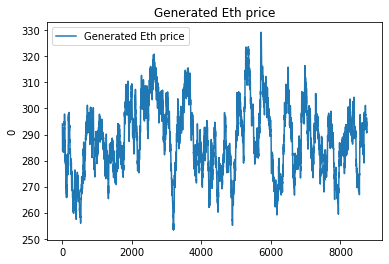

In [6]:
# Plot the ETH price for the first MC run dataset
sns.lineplot(data=eth_price_df, x=time, y="0",label='Generated Eth price')
plt.title('Generated Eth price')
plt.legend(loc="upper left")
plt.show()

# Model Configuration

In [7]:
from models.system_model_v3.model.state_variables.init import state_variables

state_variables.update({})

In [8]:
from models.system_model_v3.model.params.init import params


# Update the default parameter values
# params_update = {
#     'controller_enabled': [True],
#     'kp': [2.000000e-07], # proportional term for the stability controller: units 1/USD
#     'ki': [-5.000000e-09], # integral term for the stability controller: units 1/(USD*seconds)
# }
params_update = {
    'controller_enabled': [False],
    'liquidity_demand_shock': [False],
    'rescale_target_price': [False],
    'arbitrageur_considers_liquidation_ratio': [True,False]
}

params.update(params_update)


# Simulation Execution

In [9]:
# Set the number of simulation timesteps, with a maximum of `len(eth_price_df) - 1`
SIMULATION_TIMESTEPS = len(eth_price_df) - 1
SIMULATION_TIMESTEPS

8758

In [10]:
# Create a wrapper for the model simulation, and update the existing parameters and initial state
system_simulation = ConfigWrapper(system_model_v3, T=range(SIMULATION_TIMESTEPS), M=params, initial_state=state_variables)

In [ ]:
del configs[:] # Clear any prior configs
(simulation_result, _tensor_field, _sessions) = run(system_simulation, drop_midsteps=False) # Run the simulation


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (8758, 34, 2, 43)
Execution Method: local_simulations
SimIDs   : [0, 0]
SubsetIDs: [0, 1]
Ns       : [0, 1]
ExpIDs   : [0, 0]
Execution Mode: parallelized


# Simulation Analysis

In [ ]:
# Add new columns to dataframe
simulation_result = simulation_result.assign(eth_collateral_value = simulation_result.eth_collateral * simulation_result.eth_price)
simulation_result['collateralization_ratio'] = (simulation_result.eth_collateral * simulation_result.eth_price) / (simulation_result.principal_debt * simulation_result.target_price)

# Update dataframe display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

simulation_result

## Save simulation

In [ ]:
# Save the simulation result to a pickle file, for backup - this will be overwritten on the next simulation
#simulation_result.to_pickle(f'./exports/system_model_v3/results.pickle')
#simulation_result.to_pickle('notebooks/system_model_v3/results.pickle')

'''
1. Query: does market price decline without controller?
 ---
   - Run simulation with:
     - ETH price shock OFF
     - Liquidity shocks OFF
     - Controller OFF
     - Arbitrageur considers liquidation ratio:
       - ON
       - OFF
     - Target price rescaled:
       - ON
       - OFF
'''
simulation_result.to_pickle('notebooks/system_model_v3/query_1_results.pickle')

# Simulation Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Load the simulation result from a pickle file, specifying past results when necessary
simulation_result = pd.read_pickle('notebooks/analysis/saved_results/v3_results.pickle')

# Drop the simulation midsteps - the substeps that aren't used for generating plots
df = drop_dataframe_midsteps(simulation_result)
df

In [ ]:
df.columns

In [ ]:
# create target price scale
liquidation_ratio = 1.45
df['target_price_scaled'] = df['target_price'] * liquidation_ratio

### Generate key plots for analysis

In [ ]:
sns.lineplot(data=df,x="timestamp", y="eth_price",label='Generated Eth price')
plt.ylim(250, 600)
ax2 = plt.twinx()
sns.lineplot(data=df,x="timestamp", y="market_price",ax=ax2,color='r',label='Market Price in Rai')
sns.lineplot(data=df,x="timestamp", y="target_price_scaled",ax=ax2,color='g',label='Redemption Price in Rai')
plt.title('Generated Eth price vs Simulation Market and Redemption Prices')
plt.legend(loc="upper left")
plt.show()

In [ ]:
sns.lineplot(data=df,x="timestamp", y="eth_locked",label='Total Eth locked')
plt.legend(loc="upper left")
plt.show()

In [ ]:
sns.lineplot(data=df,x="timestamp", y="target_rate",label='Redemption Rate')
plt.legend(loc="upper left")
plt.show()

In [ ]:
sns.lineplot(data=df,x="timestamp", y="ETH_balance",label='Eth Balance')
plt.legend(loc="upper left")
plt.show()

In [ ]:
sns.lineplot(data=df,x="timestamp", y="RAI_balance",label='Rai Balance')
plt.legend(loc="upper left")
plt.show()

## Conclusion